In [22]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import optuna
import pickle
import shap
from pymongo import MongoClient
import json

In [23]:
MONGO_CONNECTION_STRING = "mongodb://localhost:27017/"
DB_NAME = "credit_risk_db"
COLLECTION_NAME = "applicants"

print("Connecting to local MongoDB to fetch training data...")
client = MongoClient(MONGO_CONNECTION_STRING)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]

cursor = collection.find({})
df_train = pd.DataFrame(list(cursor))
client.close()
print(f"Successfully loaded {len(df_train)} rows from MongoDB.")

if '_id' in df_train.columns:
    df_train = df_train.drop('_id', axis=1)

pd.set_option('display.max_columns', None)

baseline_features = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH']

df_baseline = df_train.copy()

for col in baseline_features:
    df_baseline[col].fillna(df_baseline[col].median(), inplace=True)
df_baseline[baseline_features]

Connecting to local MongoDB to fetch training data...
Successfully loaded 307511 rows from MongoDB.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7536\1778072513.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_baseline[col].fillna(df_baseline[col].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7536\1778072513.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH
0,202500.0,406597.5,24700.5,-9461
1,270000.0,1293502.5,35698.5,-16765
2,67500.0,135000.0,6750.0,-19046
3,135000.0,312682.5,29686.5,-19005
4,121500.0,513000.0,21865.5,-19932
...,...,...,...,...
307506,157500.0,254700.0,27558.0,-9327
307507,72000.0,269550.0,12001.5,-20775
307508,153000.0,677664.0,29979.0,-14966
307509,171000.0,370107.0,20205.0,-11961


In [24]:
X = df_baseline[baseline_features]
y = df_baseline['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

model = LogisticRegression(random_state=10)
model.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [25]:
val_preds = model.predict_proba(X_val)[:, 1]
baseline_auc = roc_auc_score(y_val, val_preds)

print(f"Baseline Model Validation AUC: {baseline_auc:.4f}")

Baseline Model Validation AUC: 0.5901


In [26]:
numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('TARGET')
numeric_cols.remove('SK_ID_CURR')

X = df_train[numeric_cols]
y = df_train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegression(random_state=10)
model.fit(X_train_scaled, y_train)

val_preds = model.predict_proba(X_val_scaled)[:, 1]
numeric_auc = roc_auc_score(y_val, val_preds)

print(f"Baseline Model AUC: {baseline_auc:.4f}")
print(f"Model with all numeric features AUC: {numeric_auc:.4f}")

Baseline Model AUC: 0.5901
Model with all numeric features AUC: 0.7346


In [27]:
y = df_train['TARGET']
X = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

X_train_num = X_train[numeric_cols].copy()
X_val_num = X_val[numeric_cols].copy()

imputer = SimpleImputer(strategy='median')
X_train_num_imputed = pd.DataFrame(imputer.fit_transform(X_train_num), columns=numeric_cols, index=X_train.index)
X_val_num_imputed = pd.DataFrame(imputer.transform(X_val_num), columns=numeric_cols, index=X_val.index)

scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num_imputed), columns=numeric_cols, index=X_train.index)
X_val_num_scaled = pd.DataFrame(scaler.transform(X_val_num_imputed), columns=numeric_cols, index=X_val.index)

X_train_cat = X_train[categorical_cols].copy()
X_val_cat = X_val[categorical_cols].copy()

X_train_cat_encoded = pd.get_dummies(X_train_cat)
X_val_cat_encoded = pd.get_dummies(X_val_cat)

train_cols = X_train_cat_encoded.columns

X_val_cat_final = X_val_cat_encoded.reindex(columns=train_cols, fill_value=0)

X_train_final = pd.concat([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_val_final = pd.concat([X_val_num_scaled, X_val_cat_final], axis=1)

model = LogisticRegression(random_state=10, C=0.01)
model.fit(X_train_final, y_train)

val_preds = model.predict_proba(X_val_final)[:, 1]
final_auc = roc_auc_score(y_val, val_preds)

print(f"Baseline Model AUC: {baseline_auc:.4f}")
print(f"Model with all numeric features AUC: {numeric_auc:.4f}")
print(f"Model with all features (numeric + categorical) AUC: {final_auc:.4f}")

Baseline Model AUC: 0.5901
Model with all numeric features AUC: 0.7346
Model with all features (numeric + categorical) AUC: 0.7446


In [28]:
y = df_train['TARGET']
X = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

print("Engineering new features...\n 1) total loan amount to income ratio \n 2) loan installment amount to income ratio \n 3) loan duration ")
for df in [X_train, X_val]:
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
print("New features created.")

numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

X_train_num = X_train[numeric_cols].copy()
X_val_num = X_val[numeric_cols].copy()

imputer = SimpleImputer(strategy='median')
X_train_num_imputed = pd.DataFrame(imputer.fit_transform(X_train_num), columns=numeric_cols, index=X_train.index)
X_val_num_imputed = pd.DataFrame(imputer.transform(X_val_num), columns=numeric_cols, index=X_val.index)

scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num_imputed), columns=numeric_cols, index=X_train.index)
X_val_num_scaled = pd.DataFrame(scaler.transform(X_val_num_imputed), columns=numeric_cols, index=X_val.index)

X_train_cat = X_train[categorical_cols].copy()
X_val_cat = X_val[categorical_cols].copy()

X_train_cat_encoded = pd.get_dummies(X_train_cat)
X_val_cat_encoded = pd.get_dummies(X_val_cat)

train_cols = X_train_cat_encoded.columns
X_val_cat_final = X_val_cat_encoded.reindex(columns=train_cols, fill_value=0)

# --- 6. Combine Features and Train Model ---
X_train_final = pd.concat([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_val_final = pd.concat([X_val_num_scaled, X_val_cat_final], axis=1)

model = LogisticRegression(random_state=10, C=0.01)
model.fit(X_train_final, y_train)

val_preds = model.predict_proba(X_val_final)[:, 1]
final_auc = roc_auc_score(y_val, val_preds)

print(f"Model with all features (numeric + categorical) AUC: {final_auc:.4f}")

Engineering new features...
 1) total loan amount to income ratio 
 2) loan installment amount to income ratio 
 3) loan duration 
New features created.
Model with all features (numeric + categorical) AUC: 0.7454


In [29]:
print("\nTraining XGBoost model...")

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=10)

xgb_model.fit(X_train_final, y_train)

val_preds_xgb = xgb_model.predict_proba(X_val_final)[:, 1]
xgb_auc = roc_auc_score(y_val, val_preds_xgb)

print(f"\n--- Model Performance Comparison ---")
print(f"Logistic Regression AUC: {final_auc:.4f}")
print(f"XGBoost Model AUC: {xgb_auc:.4f}")


Training XGBoost model...

--- Model Performance Comparison ---
Logistic Regression AUC: 0.7454
XGBoost Model AUC: 0.7552


In [30]:
def objective(trial):

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_final, y_train)
    
    val_preds = model.predict_proba(X_val_final)[:, 1]
    auc = roc_auc_score(y_val, val_preds)
    
    return auc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  

print("\nBest trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-09-05 23:09:03,590] A new study created in memory with name: no-name-1721a887-23a9-45b4-b358-27eda80f7051
[I 2025-09-05 23:09:37,794] Trial 0 finished with value: 0.7011755054136249 and parameters: {'n_estimators': 943, 'learning_rate': 0.28356165400819533, 'max_depth': 8, 'subsample': 0.6269970783478451, 'colsample_bytree': 0.6965734619106396}. Best is trial 0 with value: 0.7011755054136249.
[I 2025-09-05 23:09:58,480] Trial 1 finished with value: 0.7413434278372321 and parameters: {'n_estimators': 522, 'learning_rate': 0.13273001465495926, 'max_depth': 7, 'subsample': 0.6116645762290674, 'colsample_bytree': 0.898738197849906}. Best is trial 1 with value: 0.7413434278372321.
[I 2025-09-05 23:10:18,393] Trial 2 finished with value: 0.7639243514962373 and parameters: {'n_estimators': 729, 'learning_rate': 0.04157544200359387, 'max_depth': 4, 'subsample': 0.9803507381510148, 'colsample_bytree': 0.8567866213899922}. Best is trial 2 with value: 0.7639243514962373.
[I 2025-09-05 23:


Best trial:
  Value: 0.7667
  Params: 
    n_estimators: 655
    learning_rate: 0.07086322584761279
    max_depth: 4
    subsample: 0.8230284436397607
    colsample_bytree: 0.9940199173143693


In [31]:
best_params = study.best_trial.params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'auc'
best_params['random_state'] = 10

print("\nTraining final model on the full training data with best parameters...")

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_final, y_train)

with open('../models/xgb_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

imputer = SimpleImputer(strategy='median').fit(X_train[numeric_cols])
scaler = StandardScaler().fit(imputer.transform(X_train[numeric_cols]))
train_cols = X_train_cat_encoded.columns # from the one-hot encoding step

with open('../models/imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)
    
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('../models/train_cols.pkl', 'wb') as f:
    pickle.dump(train_cols, f)

print("Final model and preprocessing objects saved to the 'models' directory.")


Training final model on the full training data with best parameters...
Final model and preprocessing objects saved to the 'models' directory.


In [32]:
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

with open('../models/categorical_cols.pkl', 'wb') as f:
    pickle.dump(categorical_cols, f)

print("Saved categorical columns list.")

final_model_columns = X_train_final.columns.tolist()

with open('../models/final_model_columns.pkl', 'wb') as f:
    pickle.dump(final_model_columns, f)

print("Saved final model columns list.")

Saved categorical columns list.
Saved final model columns list.


SHAP values calculated successfully.

Generating SHAP Summary Plot...


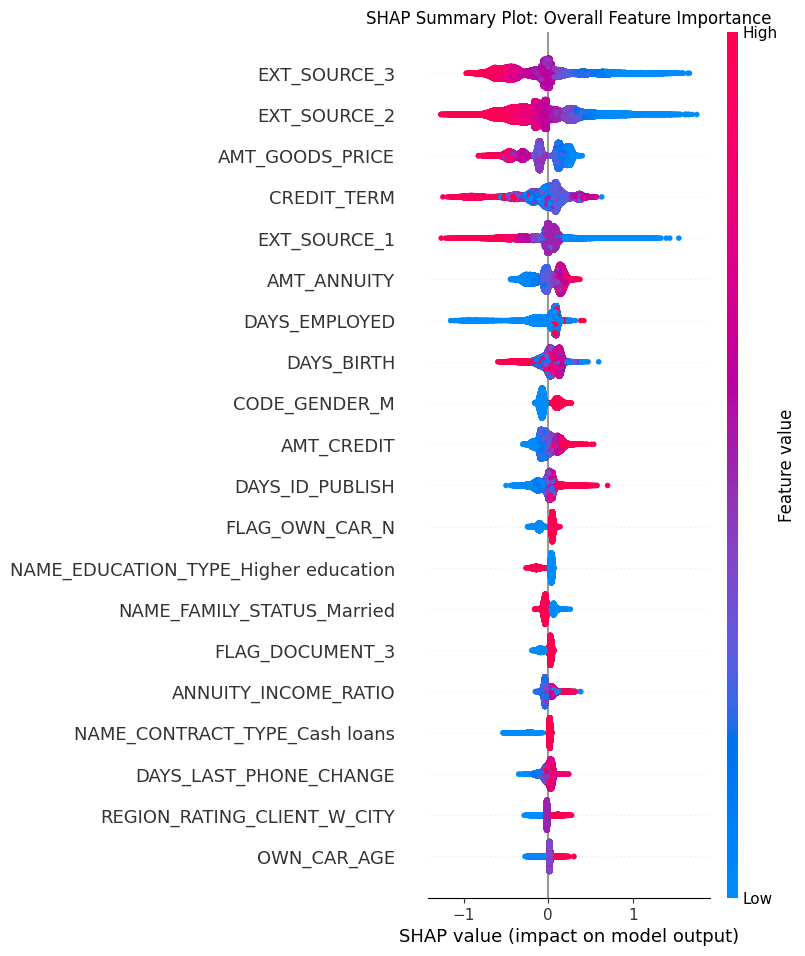


Generating Interactive SHAP Force Plot for a single default prediction...


In [33]:
with open('../models/xgb_model.pkl', 'rb') as f:
    final_model = pickle.load(f)

explainer = shap.TreeExplainer(final_model)

shap_values = explainer.shap_values(X_val_final)
print("SHAP values calculated successfully.")

print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_val_final, show=False)
plt.title("SHAP Summary Plot: Overall Feature Importance")
plt.savefig('../SHAP_Summary_Plot.png', bbox_inches='tight')
plt.show()

print("\nGenerating Interactive SHAP Force Plot for a single default prediction...")

shap.initjs()

default_index = y_val[y_val == 1].index[0]
default_loc = X_val_final.index.get_loc(default_index)

shap.force_plot(
    explainer.expected_value, 
    shap_values[default_loc, :], 
    X_val_final.iloc[default_loc, :]
)